# Modelo predictivo: precio de un auto

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Esta app sirve para averiguar rápidamente el valor de mercado de un coche al quererlo vender. 

Se tiene acceso al historial de datos de Rusty Bargain: especificaciones técnicas, versiones de equipamiento y precios. 

Hay que crear un modelo que determine el valor de mercado tomando en cuenta los siguientes parámetros:
- el tiempo requerido para el entrenamiento
- la velocidad de la predicción
- la calidad de la predicción

## Inicialización y preparación de datos

### Importar librerias y vista previa

In [1]:
#Importar librerias
import pandas as pd 
import numpy as np 
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor

from catboost import CatBoostRegressor, Pool
import lightgbm as ltb 
import xgboost as xg

In [2]:
#Cargar archivos de datos
df = pd.read_csv('/datasets/car_data.csv')
df_initial_size = df.shape[0]

#vista previa
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
335581,27/03/2016 23:37,1900,convertible,2001,manual,136,2_reihe,150000,6,petrol,peugeot,no,27/03/2016 00:00,0,63110,06/04/2016 09:16
65608,09/03/2016 19:53,550,wagon,1998,manual,68,astra,150000,11,gasoline,opel,yes,09/03/2016 00:00,0,24539,05/04/2016 14:18
346359,02/04/2016 15:51,2500,small,2002,manual,105,a_klasse,150000,2,petrol,mercedes_benz,no,02/04/2016 00:00,0,26802,06/04/2016 14:45
112365,08/03/2016 14:49,999,wagon,2002,NaN,116,focus,150000,5,gasoline,ford,NaN,08/03/2016 00:00,0,59425,11/03/2016 08:15
64168,04/04/2016 23:47,4750,convertible,2005,manual,0,megane,50000,3,petrol,renault,no,04/04/2016 00:00,0,94469,07/04/2016 05:16


In [3]:
#vista previa
df.tail()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15
354368,20/03/2016 19:41,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,20/03/2016 00:00,0,40764,24/03/2016 12:45


In [4]:
# información general
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 354369 entries, 0 to 354368

Data columns (total 16 columns):

 #   Column             Non-Null Count   Dtype 

---  ------             --------------   ----- 

 0   DateCrawled        354369 non-null  object

 1   Price              354369 non-null  int64 

 2   VehicleType        316879 non-null  object

 3   RegistrationYear   354369 non-null  int64 

 4   Gearbox            334536 non-null  object

 5   Power              354369 non-null  int64 

 6   Model              334664 non-null  object

 7   Mileage            354369 non-null  int64 

 8   RegistrationMonth  354369 non-null  int64 

 9   FuelType           321474 non-null  object

 10  Brand              354369 non-null  object

 11  NotRepaired        283215 non-null  object

 12  DateCreated        354369 non-null  object

 13  NumberOfPictures   354369 non-null  int64 

 14  PostalCode         354369 non-null  int64 

 15  LastSeen           354369 non-null  object

dtyp

In [5]:
# descripción general
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Descripción de los datos
- `DateCrawled` - fecha en la que se descargó el perfil de la base de datos
- `Price` - precio al que se vende el vehículo
- `VehicleType` - tipo de carrocería del vehículo
- `RegistrationYear` - año de matriculación del vehículo
- `Gearbox` - tipo de caja de cambios
- `Power` - potencia en CV (caballos de vapor)
- `Model` - modelo del vehículo
- `Mileage` - kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
- `RegistrationMonth` - mes de matriculación del vehículo
- `FuelType` - tipo de combustible
- `Brand` - marca del vehículo
- `NotRepaired` - vehículo con o sin reparación
- `DateCreated` - fecha de creación del perfil
- `NumberOfPictures` - número de fotos del vehículo
- `PostalCode` - código postal del propietario del perfil (usuario)
- `LastSeen` - fecha de la última vez que el usuario estuvo activo

In [6]:
#valores ausentes por columna 
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [7]:
#porcentaje de valores ausentes por columna 
df.isna().sum()/df.shape[0]*100

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Mileage               0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
NotRepaired          20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

Al analizar la información del conjunto de datos se sabe que:
- Las columnas `DateCrawled`, `DateCreated` y `LastSeen` deberían ser tipo datetime pero no son relevantes para el modelo. 
- Hay valores ausentes en las columnas `VehicleType`, `Gearbox`, `Model`, `FuelType` y `NotRepaired`
- Las columnas `Price`, `Power` y `RegistrationMonth` tienen celdas con valores en 0, valor anormal.
- La columna `RegistrationYear`tiene años muy antiguos y algunos sin ocurrir al momento del análisis.
- La columna `NumberOfPictures` tiene todas sus celdas en 0.


### Preprocesamiento de datos 

#### Cambiar tipo de dato de columnas

In [8]:
#vista previa de columnas con fechas
df.loc[:,['DateCrawled', 'DateCreated', 'LastSeen','RegistrationYear']].head()

,DateCrawled,DateCreated,LastSeen,RegistrationYear
0,24/03/2016 11:52,24/03/2016 00:00,07/04/2016 03:16,1993
1,24/03/2016 10:58,24/03/2016 00:00,07/04/2016 01:46,2011
2,14/03/2016 12:52,14/03/2016 00:00,05/04/2016 12:47,2004
3,17/03/2016 16:54,17/03/2016 00:00,17/03/2016 17:40,2001
4,31/03/2016 17:25,31/03/2016 00:00,06/04/2016 10:17,2008


In [9]:
#convertir columnas a tipo fecha
for col in ['DateCrawled', 'DateCreated', 'LastSeen']:
    df[col] = pd.to_datetime(df[col],  infer_datetime_format=True)

In [10]:
#tomar solo los años de cada columna
for col in ['DateCrawled', 'DateCreated', 'LastSeen']:
    df[col] = pd.DatetimeIndex(df[col]).year 

df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016,0,70435,2016
1,2016,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016,0,66954,2016
2,2016,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016,0,90480,2016
3,2016,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016,0,91074,2016
4,2016,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016,0,60437,2016


#### Eliminar columna vacia

Se eliminan la columna `NumberOfPictures` ya que tiene todas sus celdas en 0.

In [11]:
#eliminar columna
df = df.drop('NumberOfPictures',axis=1)

#### valores ausentes

Se eliminan los renglones con valores ausentes en las columnas `Gearbox` y `Model` pues tienen un porcentaje de ausentes bajo.

In [12]:
#eliminar renglones de  columnas Gearbox y Model
df = df.dropna(subset=['Gearbox','Model'])

Observar nuevamente el porcentaje de valores ausentes.

In [13]:
#porcentaje de valores ausentes por columna 
df.isna().sum()/df.shape[0]*100

DateCrawled           0.000000
Price                 0.000000
VehicleType           7.431606
RegistrationYear      0.000000
Gearbox               0.000000
Power                 0.000000
Model                 0.000000
Mileage               0.000000
RegistrationMonth     0.000000
FuelType              6.186944
Brand                 0.000000
NotRepaired          16.529555
DateCreated           0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

**Valores ausentes - columna `VehicleType`**

Se analiza la columna para elegir el mejor valor para sustituir los valores ausentes.

In [14]:
#Vista previa donde VehicleType tiene valores ausentes
df[df['VehicleType'].isna()].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,2016,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016,70435,2016
22,2016,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016,49716,2016
26,2016,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016,31139,2016
31,2016,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016,37075,2016
35,2016,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016,19386,2016


In [15]:
#tipos de vehiculo
df['VehicleType'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

In [16]:
#cantidad de vehiculos por tipo
df['VehicleType'].sort_values().value_counts()

sedan          85937
small          73614
wagon          61436
bus            27081
convertible    18722
coupe          14851
suv            10959
other           2658
Name: VehicleType, dtype: int64

In [17]:
#top 11 modelos de los vehiculos que se desconoce el tipo
df[df['VehicleType'].isna()]['Model'].value_counts().head(11)

golf        3266
other       1213
polo        1182
corsa       1162
3er         1048
astra        966
a3           675
passat       537
twingo       477
a_klasse     467
fiesta       465
Name: Model, dtype: int64

In [18]:
#buscar moda de cada modelo
model_mode = df.groupby('Model')['VehicleType'].agg(pd.Series.mode)

In [19]:
#buscar valor modal para los primeros 10 tipos de vehiculos que aparecen en el df y que tienen valores ausentes
for vtype in ['golf', 'polo', 'corsa', '3er', 'astra','a3','passat','twingo','a_klasse','fiesta']:
    print (vtype,':',model_mode[vtype])

golf : sedan

polo : small

corsa : small

3er : sedan

astra : sedan

a3 : sedan

passat : wagon

twingo : small

a_klasse : sedan

fiesta : small


In [20]:
#asignar valores modales
df['VehicleType'] = np.where(
    (df['VehicleType'].isna()==True) & (df['Model'].isin(['golf','3er','astra','a3','a_klasse'])),'sedan',
    np.where((df['VehicleType'].isna()==True) & (df['Model'].isin(['polo','corsa','twingo'])),'small',
    np.where((df['VehicleType'].isna()==True) & (df['Model'] == 'passat')                    ,'wagon','other')))

#verificar cambios
df[df['VehicleType'].isna()].value_counts()

Series([], dtype: int64)

**Valores ausentes - columna `FuelType`**

Se analiza la columna para elegir el mejor valor para sustituir los valores ausentes.

In [21]:
#cantidad de vehiculos por cada tipo de combustible
df['FuelType'].value_counts()

petrol      200925
gasoline     92547
lpg           4854
cng            531
hybrid         203
other          108
electric        60
Name: FuelType, dtype: int64

Dado que el tipo de gasolina es un dato que influye altamente en el costo de un vehiculo, se opta por llenar los valores ausentes con el valor `unknown` (desconocido).

In [22]:
#llenar valores ausentes en FuelType
df['FuelType'] = df['FuelType'].fillna('unknown')

**Valores ausentes - columna `NotRepaired`**

Se analiza la columna para elegir el mejor valor para sustituir los valores ausentes.

In [23]:
#cantidad de vehiculos con y sin reparaciones
df['NotRepaired'].value_counts()

no     233822
yes     32417
Name: NotRepaired, dtype: int64

In [24]:
#llenar valores ausentes en columna NotRepaired
df['NotRepaired'] = df['NotRepaired'].fillna('no')

La mayoría de los vehiculos no han sido reparados, se asume este como valor representativo.

In [25]:
#verificar cambios
df.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 318962 entries, 0 to 354368

Data columns (total 15 columns):

 #   Column             Non-Null Count   Dtype 

---  ------             --------------   ----- 

 0   DateCrawled        318962 non-null  int64 

 1   Price              318962 non-null  int64 

 2   VehicleType        318962 non-null  object

 3   RegistrationYear   318962 non-null  int64 

 4   Gearbox            318962 non-null  object

 5   Power              318962 non-null  int64 

 6   Model              318962 non-null  object

 7   Mileage            318962 non-null  int64 

 8   RegistrationMonth  318962 non-null  int64 

 9   FuelType           318962 non-null  object

 10  Brand              318962 non-null  object

 11  NotRepaired        318962 non-null  object

 12  DateCreated        318962 non-null  int64 

 13  PostalCode         318962 non-null  int64 

 14  LastSeen           318962 non-null  int64 

dtypes: int64(9), object(6)

memory usage: 38.9+ MB


In [26]:
print('Se eliminó el',round((df_initial_size-df.shape[0]) /df_initial_size*100,2),'% de los datos')

Se eliminó el 9.99 % de los datos


#### Analizar columnas categóricas

Se analizan las características categorícas en busca de valores anormales.
Se continua con las columnas que no se han analizado previamente. 

In [27]:
for col in ['RegistrationYear','Gearbox','Model','Brand']:
    print('\n',col)
    print(df[col].sort_values().unique())



 RegistrationYear

[1000 1200 1400 1500 1600 1602 1910 1919 1923 1927 1928 1929 1930 1931

 1932 1933 1934 1935 1936 1937 1938 1942 1943 1945 1947 1950 1951 1952

 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966

 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980

 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994

 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008

 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2900 3000 3700

 4000 4500 5000 5911 6000 6500 7100 7500 8200 9000]



 Gearbox

['auto' 'manual']



 Model

['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'

 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'

 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'

 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'

 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'

 'b_max' 'beetle' 'berl

Se encuentran valores irrelevantes para el modelo en la columna `RegistrationYear` pues tiene años muy antiguos al analisis, se toman como relevantes los años posteriores a 1909 hasta el año 2019.

Las columnas `Model` y `Brand` tienen muchas opciones de texto distintas.

**Columna `RegistrationYear`**

In [28]:
#Eliminar renglones con años de registro irrelevantes
df = df.loc[(df['RegistrationYear']>1909) & (df['RegistrationYear']<2020)]

**Columna `Brand`**

In [29]:
#Cantidad de marcas
len(df['Brand'].sort_values().unique())

39

In [30]:
#porcentaje de marcas
df.groupby('Brand')['Price'].count().sort_values(ascending=False) / df.shape[0]*100

Brand
volkswagen       21.810577
opel             11.316341
bmw              10.618398
mercedes_benz     9.325039
audi              8.490392
ford              7.194211
renault           5.081568
peugeot           3.057030
fiat              2.690186
seat              2.013250
skoda             1.641076
mazda             1.588401
citroen           1.462985
nissan            1.424419
toyota            1.349796
smart             1.292732
hyundai           1.019324
mini              0.962573
volvo             0.940311
mitsubishi        0.861299
honda             0.804234
kia               0.712993
suzuki            0.654361
alfa_romeo        0.649345
chevrolet         0.492260
chrysler          0.408858
dacia             0.268705
daihatsu          0.225750
subaru            0.216344
porsche           0.204429
jeep              0.195336
land_rover        0.158652
saab              0.155517
jaguar            0.148619
daewoo            0.147992
lancia            0.132628
rover             0.12

In [31]:
#agrupar marcas que representan menos del 2% de la información cada una
top10_brands = ['volkswagen', 'opel', 'bmw', 'mercedes_benz', 'audi', 'ford', 'renault', 'peugeot', 'fiat', 'seat']

df['Brand'] = df['Brand'].where(df['Brand'].isin(top10_brands),'other')

In [32]:
#Cantidad de marcas tras agrupacion
len(df['Brand'].sort_values().unique())

11

**Columna `Model`**

In [33]:
#Cantidad de modelos
len(df['Model'].sort_values().unique())

250

Dado que se tienen demasiados modelos, se ignora esta columna para la creación del modelo.

In [34]:
df = df.drop('Model',axis=1)

#### Analizar columnas numéricas

Se analizan los valores de las columnas numéricas en busca de valores anormales.

- `Price` - precio al que se vende el vehículo
- `Power` - potencia en CV (caballos de vapor)
- `Mileage` - kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)

In [35]:
#descripción columnas numéricas
df.loc[:,['Price','Power','Mileage']].describe()

,Price,Power,Mileage
count,318937.000000,318937.000000,318937.000000
mean,4608.926465,114.954351,128852.375234
std,4564.218542,185.587771,36608.946358
min,0.000000,0.000000,5000.000000
25%,1200.000000,75.000000,125000.000000
50%,2900.000000,105.000000,150000.000000
75%,6700.000000,143.000000,150000.000000
max,20000.000000,20000.000000,150000.000000


Se observan valores extañamente bajos en las columnas `Price` y `Power`. 

El 75% de los vehiculos tienen:
- precio mayor a 1,200
- potencia mayor a 75

In [36]:
df.shape[0]**0.5

564.7450752330648

Las columnas `Price` y `Power` tienen valores extrañamente bajos.

A continuación se visualizan los valores mencionados. Para mejorar la visualización, se usa la regla de la raíz cuadrada para determinar un valor óptimo de bins, esto es usar la raíz cuadrada del número total de muestras en el conjunto de datos como aproximación.

In [37]:
#obtener un valor optimo para los bins
( df[df['Price']<1200]['Price'].shape[0] )**0.5

280.3176769310134

In [38]:
#obtener un valor optimo para los bins
( df[df['Power']<50]['Price'].shape[0] )**0.5

169.44910740396364

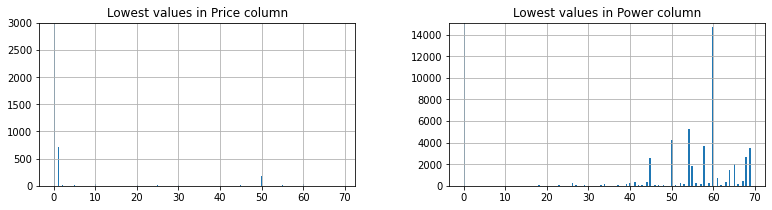

In [39]:
#graficar valores extrañamente bajos
plt.subplots(figsize=(13, 3)) 

df[df['Price']<70].hist(column='Price',ax=plt.subplot(1,2, 1),bins = 280)
plt.title('Lowest values in Price column') 
plt.ylim(0,3000)

df[df['Power']<70].hist(column='Power',ax=plt.subplot(1, 2, 2),bins = 170)
plt.title('Lowest values in Power column') 
plt.ylim(0,15100)
plt.show() 

In [40]:
#eliminar valores anormalmente bajos en columna Price y Power
df = df.loc[(df['Price']>60) & (df['Power']>30)]

#verificar cambios
df.describe()

,DateCrawled,Price,RegistrationYear,Power,Mileage,RegistrationMonth,DateCreated,PostalCode,LastSeen
count,288069.0,288069.000000,288069.000000,288069.000000,288069.000000,288069.000000,288069.000000,288069.000000,288069.0
mean,2016.0,4904.044149,2003.394169,124.386702,128552.846714,6.033079,2015.999920,51273.774575,2016.0
std,0.0,4608.329891,6.624654,187.355685,36390.058103,3.566548,0.008935,25751.126451,0.0
min,2016.0,65.000000,1910.000000,31.000000,5000.000000,0.000000,2015.000000,1067.000000,2016.0
25%,2016.0,1399.000000,1999.000000,78.000000,125000.000000,3.000000,2016.000000,30966.000000,2016.0
50%,2016.0,3250.000000,2003.000000,113.000000,150000.000000,6.000000,2016.000000,50321.000000,2016.0
75%,2016.0,7000.000000,2008.000000,150.000000,150000.000000,9.000000,2016.000000,72108.000000,2016.0
max,2016.0,20000.000000,2019.000000,20000.000000,150000.000000,12.000000,2016.000000,99998.000000,2016.0


In [41]:
#verificar cambios
df.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 288069 entries, 2 to 354368

Data columns (total 14 columns):

 #   Column             Non-Null Count   Dtype 

---  ------             --------------   ----- 

 0   DateCrawled        288069 non-null  int64 

 1   Price              288069 non-null  int64 

 2   VehicleType        288069 non-null  object

 3   RegistrationYear   288069 non-null  int64 

 4   Gearbox            288069 non-null  object

 5   Power              288069 non-null  int64 

 6   Mileage            288069 non-null  int64 

 7   RegistrationMonth  288069 non-null  int64 

 8   FuelType           288069 non-null  object

 9   Brand              288069 non-null  object

 10  NotRepaired        288069 non-null  object

 11  DateCreated        288069 non-null  int64 

 12  PostalCode         288069 non-null  int64 

 13  LastSeen           288069 non-null  int64 

dtypes: int64(9), object(5)

memory usage: 33.0+ MB


In [42]:
print('Se conserva el',round(df.shape[0] /df_initial_size*100,2),'% de los datos iniciales')

Se conserva el 81.29 % de los datos iniciales


No hay valores ausentes ni valores anormales y los datos son del tipo correcto.

## Exploración de características para el modelo

### Características numéricas

In [43]:
#matriz de correlación
df.corr()

,DateCrawled,Price,RegistrationYear,Power,Mileage,RegistrationMonth,DateCreated,PostalCode,LastSeen
DateCrawled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,NaN,1.000000,0.462309,0.140261,-0.397330,0.062129,-0.003911,0.063401,NaN
RegistrationYear,NaN,0.462309,1.000000,0.030079,-0.302457,0.022713,-0.000524,0.019630,NaN
Power,NaN,0.140261,0.030079,1.000000,0.024070,0.009467,0.000151,0.009550,NaN
Mileage,NaN,-0.397330,-0.302457,0.024070,1.000000,-0.016941,0.004609,-0.012362,NaN
RegistrationMonth,NaN,0.062129,0.022713,0.009467,-0.016941,1.000000,0.002806,0.002656,NaN
DateCreated,NaN,-0.003911,-0.000524,0.000151,0.004609,0.002806,1.000000,0.001626,NaN
PostalCode,NaN,0.063401,0.019630,0.009550,-0.012362,0.002656,0.001626,1.000000,NaN
LastSeen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


La matriz de correlación muestra
- una relación positiva entre el precio y el año de matriculación del vehículo
- poca relación entre el precio y la potencia
- una relación negativa entre el precio y el kilometraje 
- que no hay relación entre el precio y:
    - el mes de matriculación del vehículo
    - el año de creacion del perfil
    - el codigo postal del propietario del perfil (usuario)
    - la fecha de la última vez que el usuario estuvo activo
    
Se crea una matriz de dispersión sin tomar en cuenta las columnas que no influyen en el precio.

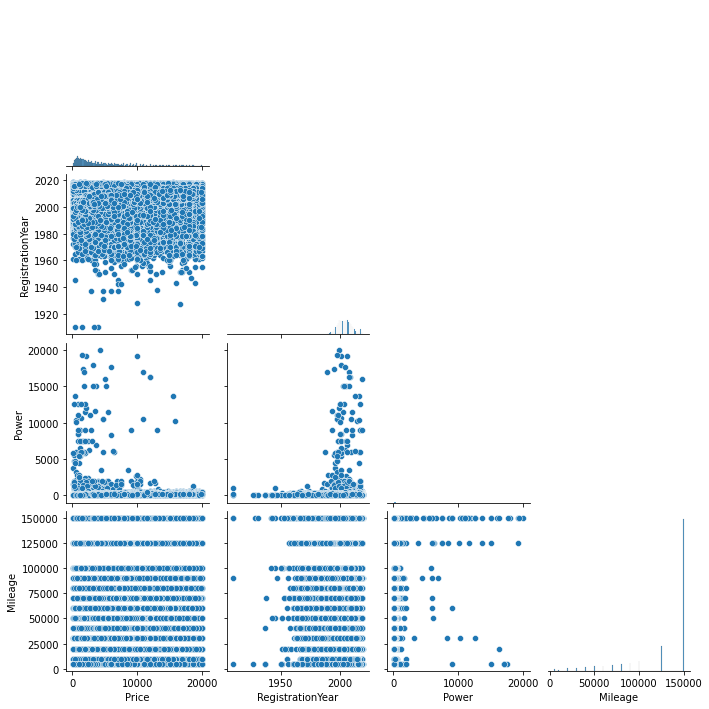

In [44]:
#matriz de dispersión
sns.pairplot(df.loc[:,['Price', 'RegistrationYear', 'Power', 'Mileage', 'NotRepaired']],corner=True)
plt.show()

La mátriz de dispersión muestra que se tiene más información de vehiculos con años de registro cercanos a la fecha actual.

### Caracteristicas categoricas

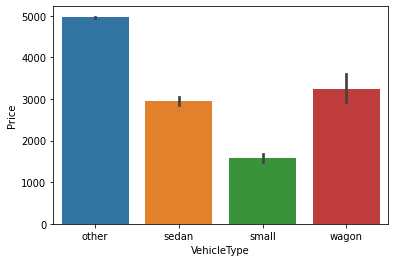

In [45]:
#promedio del precio por tipo de vehiculo
sns.barplot(data=df, x='VehicleType', y='Price')
plt.show()

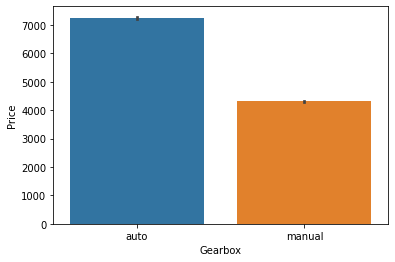

In [46]:
#promedio del precio por ipo de caja de cambios
sns.barplot(data=df, x='Gearbox', y='Price')
plt.show()

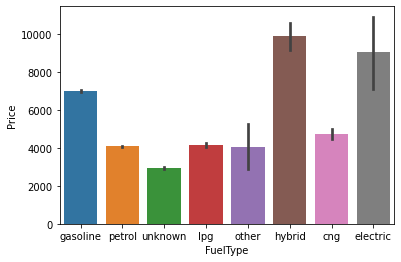

In [47]:
#promedio del precio por tipo combustible
sns.barplot(data=df, x='FuelType', y='Price')
plt.show()

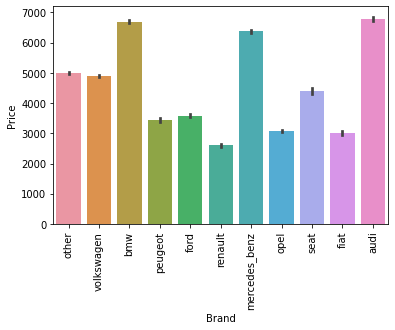

In [48]:
#promedio del precio por marca
sns.barplot(data=df, x='Brand', y='Price')
plt.xticks(rotation='vertical')
plt.show()

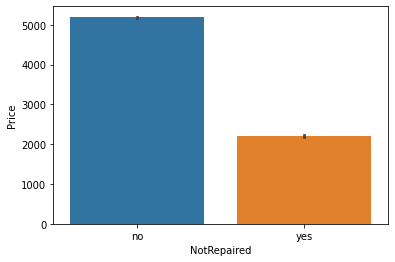

In [49]:
#promedio del precio en vehiculos con y sin reparaciones
sns.barplot(data=df, x='NotRepaired', y='Price')
plt.show()

En todas las características categoricas, hay diferencias significativas en los promedios de cada categóría por lo que se toman en cuenta. 

En base a los análisis anteriores se escogen los siguientes datos para la creación del modelo:

**Columna objetivo:**
- `Price` - precio al que se vende el vehículo

**Columnas con características:**
- `VehicleType` - tipo de carrocería del vehículo
- `RegistrationYear` - año de matriculación del vehículo
- `Gearbox` - tipo de caja de cambios
- `Power` - potencia (CV)
- `Mileage` - kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
- `FuelType` - tipo de combustible
- `Brand` - marca del vehículo
- `NotRepaired` - vehículo con o sin reparación

## Entrenamiento y validación de los modelos 

Se comparan distintos modelos por medio de la métrica **raíz del error cuadrático medio (RECM)**. Asimismo, se analiza la velocidad de los modelos. 

Los modelos analizados son:
- Modelo de regresión lineal (se usa como base para la prueba de cordura)
- Modelo árbol de decision
- Modelo bosque aleatorio
- LightGBM
- CatBoost
- XGBoost

**Peparar datos para entrenar y validar los modelos**

In [50]:
#explorar columnas
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Mileage', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'PostalCode', 'LastSeen'],
      dtype='object')

In [51]:
#Separar conjunto de entrenamiento en objetivo y características
target = df['Price']
features = df.drop(['DateCrawled', 'Price', 'RegistrationMonth', 'DateCreated','PostalCode', 'LastSeen'], axis=1)

In [52]:
#Separar datos en conjunto de entrenamiento(75%) y validación (25%)
train_features, valid_features, train_target, valid_target = train_test_split(features, target,
                                                                              test_size=0.25, random_state=12345 )

Aplicar codificación One-Hot (OHE) para transformar características categóricas en numéricas.

In [53]:
#aplicar OHE
features_ohe = pd.get_dummies(features,drop_first=True) 

#Separar datos en conjunto de entrenamiento(75%) y validación (25%)
train_features_ohe, valid_features_ohe, train_target_ohe, valid_target_ohe = train_test_split(features_ohe, target,
                                                                              test_size=0.25, random_state=12345 )

Se crea función para calcular tiempo de entrenamiento y tiempo para hacer predicciónes

In [54]:
#función para calcular tiempo de entrenamiento y de predicciónes
def train_and_pred_time(model,model_name,train_features, train_target,valid_features):
    #tiempo antes del entrenamiento
    start_time1 = time.time()
    
    #entrenar modelo
    if model_name == 'cbr':
        model.fit(train_features)
    else: 
        model.fit(train_features, train_target)
    
    #tiempo después del entrenamiento
    end_time1 = time.time()
    
    #duración del entrenamiento
    train_time = end_time1 - start_time1
    
    #tiempo antes de la predicción
    start_time2 = time.time()
    
    #prediccion de datos de validación
    predictions = model.predict(valid_features)
    
    #tiempo después de la predicción
    end_time2 = time.time()
    
    #duración de la predicción
    pred_time = end_time2 - start_time2
    
    return train_time, pred_time, predictions

### Modelo de regresión lineal

In [55]:
#fijar modelo
model_lr = LinearRegression() 

#usar función para calcular tiempo y predicciones
lr_train_time, lr_pred_time, lr_pred = train_and_pred_time(model_lr, 'lr', train_features_ohe, train_target_ohe,
                                                           valid_features_ohe)

In [56]:
# raíz del error cuadrático medio
lr_train_rmse = round(mean_squared_error(train_target_ohe, model_lr.predict(train_features_ohe)),2)
lr_valid_rmse = round(mean_squared_error(valid_target_ohe,lr_pred),2)

print('RMSE training set:   ',lr_train_rmse) 
print('RMSE validation set: ',lr_valid_rmse) 

RMSE training set:    10372813.19

RMSE validation set:  10508270.42


**Modelo de regresión lineal con uso de descenso de gradiente estocástico**

In [57]:
#aplicar ohe a datos categoricos
ohe = OneHotEncoder(drop='first', sparse=False)
train_features_encoded = ohe.fit_transform(train_features.select_dtypes(include=['object']))
valid_features_encoded = ohe.transform(valid_features.select_dtypes(include=['object']))


#escalar datos numericos
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features.select_dtypes(include=['number']))
valid_features_scaled = scaler.transform(valid_features.select_dtypes(include=['number']))

#unir datos categoricos con numéricos
train_features_final = np.hstack((train_features_encoded, train_features_scaled))
valid_features_final = np.hstack((valid_features_encoded, valid_features_scaled))

In [58]:
#fijar modelo
model_sgd = SGDRegressor(max_iter=1000, tol=1e-3, random_state=12345)

#usar función para calcular tiempo y predicciones
sgd_train_time, sgd_pred_time, sgd_pred = train_and_pred_time(model_sgd, 'sgd', train_features_final, train_target,
                                                           valid_features_final)

In [59]:
# raíz del error cuadrático medio
sgd_train_rmse = round(mean_squared_error(train_target, model_lr.predict(train_features_final)),2)
sgd_valid_rmse = round(mean_squared_error(valid_target,sgd_pred),2)

print('RMSE training set:   ',sgd_train_rmse) 
print('RMSE validation set: ',sgd_valid_rmse) 

RMSE training set:    245315326587.82

RMSE validation set:  10535517.78


El valor RMSE del primer modelo tuvo un mejor desempeño, se usa este para la comparación.

### Modelo de árbol de decisión

In [60]:
#buscar las mejores características con GridSearchCV, para encontrar la mejor profundidad de árbol
param_grid = {'max_depth': [1,2,4,6,8,10,15,20]}

tree_reg = DecisionTreeRegressor(random_state=12345)
grid_search = GridSearchCV(estimator=tree_reg, param_grid=param_grid, cv=5, verbose=True)
%time grid_search.fit(train_features_ohe, train_target_ohe)

final_model = grid_search.best_estimator_
final_model

Fitting 5 folds for each of 8 candidates, totalling 40 fits

CPU times: user 18.5 s, sys: 352 ms, total: 18.8 s

Wall time: 18.9 s


DecisionTreeRegressor(max_depth=15, random_state=12345)

In [61]:
#fijar modelo con parámetros encontrados
model_dtr = DecisionTreeRegressor(random_state=12345, max_depth=15)

#usar función para calcular tiempo y predicciones
dtr_train_time, dtr_pred_time, dtr_pred = train_and_pred_time(model_dtr, 'dtr', train_features_ohe, train_target_ohe,
                                                           valid_features_ohe)

In [62]:
# raíz del error cuadrático medio
dtr_train_rmse = round(mean_squared_error(train_target_ohe, model_dtr.predict(train_features_ohe)),2)
dtr_valid_rmse = round(mean_squared_error(valid_target_ohe, dtr_pred),2)

print('RMSE training set:   ',dtr_train_rmse) 
print('RMSE validation set: ',dtr_valid_rmse) 

RMSE training set:    2592833.38

RMSE validation set:  3712084.25


### Modelo bosque aleatorio de decisión

In [63]:
#buscar las mejores características para los datos disponibles
model_rfr =RandomForestRegressor(random_state=12345)
param_grid = {'n_estimators': [1,2,3,4,6,8,10],'max_features': [ 'sqrt', 'log2'],'max_depth' : [2,3,4,5,6,8,10]}
CV_rfr = GridSearchCV(estimator=model_rfr, param_grid=param_grid, cv= 5)
CV_rfr.fit(train_features_ohe,train_target_ohe)
CV_rfr.best_params_

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 10}

In [64]:
#fijar modelo con parámetros encontrados
model_rfr = RandomForestRegressor(random_state=12345, max_depth=10, max_features= 'sqrt',n_estimators=10)

#usar función para calcular tiempo y predicciones
rfr_train_time, rfr_pred_time, rfr_pred = train_and_pred_time(model_rfr, 'rfr', train_features_ohe, train_target_ohe,
                                                           valid_features_ohe)

In [65]:
# raíz del error cuadrático medio
rfr_train_rmse = round(mean_squared_error(train_target_ohe, model_rfr.predict(train_features_ohe) ),2)
rfr_valid_rmse = round(mean_squared_error(valid_target_ohe, rfr_pred),2)

print('RMSE training set:   ', rfr_train_rmse) 
print('RMSE validation set: ', rfr_valid_rmse) 

RMSE training set:    4688229.51

RMSE validation set:  4836478.22


### LightGBM
Esta biblioteca requere OHE.

In [66]:
#fijar modelo 1
model_ltb1= ltb.LGBMRegressor(boosting_type='gbdt',num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100)

#usar función para calcular tiempo y predicciones
ltb_train_time1, ltb_pred_time1, ltb_pred1 = train_and_pred_time(model_ltb1, 'ltb', train_features_ohe, train_target_ohe,
                                                           valid_features_ohe)

In [67]:
# raíz del error cuadrático medio - modelo 1
ltb1_train_rmse = round(mean_squared_error(train_target, model_ltb1.predict(train_features_ohe) ),2)
ltb1_valid_rmse = round(mean_squared_error(valid_target, ltb_pred1),2)

print('RMSE training set:   ', ltb1_train_rmse) 
print('RMSE validation set: ', ltb1_valid_rmse) 

RMSE training set:    3383202.17

RMSE validation set:  3478602.87


In [68]:
#fijar modelo 2 - ajuste en hiperparámetros
model_ltb2=ltb.LGBMRegressor(boosting_type='gbdt',num_leaves=20, max_depth=10, learning_rate=0.05, n_estimators=100)

#usar función para calcular tiempo y predicciones
ltb_train_time2, ltb_pred_time2, ltb_pred2 = train_and_pred_time(model_ltb2, 'ltb', train_features_ohe, train_target_ohe,
                                                           valid_features_ohe)

In [69]:
# raíz del error cuadrático medio - modelo 2
ltb2_train_rmse = round(mean_squared_error(train_target_ohe, model_ltb2.predict(train_features_ohe) ),2)
ltb2_valid_rmse = round(mean_squared_error(valid_target_ohe, ltb_pred2 ),2)

print('RMSE training set:   ', ltb2_train_rmse) 
print('RMSE validation set: ', ltb2_valid_rmse) 

RMSE training set:    3813317.11

RMSE validation set:  3851244.06


Los primeros parametros resultan en un menor resultado RMSE, por ello, se toma este modelo como el mejor de los dos.

### CatBoost

Esta biblioteca no requere OHE.

In [70]:
#explorar tipos de datos
train_features.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 216051 entries, 316635 to 267686

Data columns (total 8 columns):

 #   Column            Non-Null Count   Dtype 

---  ------            --------------   ----- 

 0   VehicleType       216051 non-null  object

 1   RegistrationYear  216051 non-null  int64 

 2   Gearbox           216051 non-null  object

 3   Power             216051 non-null  int64 

 4   Mileage           216051 non-null  int64 

 5   FuelType          216051 non-null  object

 6   Brand             216051 non-null  object

 7   NotRepaired       216051 non-null  object

dtypes: int64(3), object(5)

memory usage: 14.8+ MB


In [71]:
#identificar datos categoricos
categorical_features_indices = [0,2,5,6,7]
train_data = Pool(data = train_features, label = train_target, cat_features = categorical_features_indices)

#fijar el modelo
model_cbr = CatBoostRegressor(iterations=100, random_seed=123456, verbose=False)

#usar función para calcular tiempo y predicciones
cbr_train_time, cbr_pred_time, cbr_pred = train_and_pred_time(model_cbr, 'cbr', train_data, train_target, valid_features)

In [72]:
# raíz del error cuadrático medio
cbr_train_rmse = round(mean_squared_error(train_target, model_cbr.predict(train_features) ),2)
cbr_valid_rmse = round(mean_squared_error(valid_target, model_cbr.predict(valid_features) ),2)

print('RMSE training set:   ', cbr_train_rmse) 
print('RMSE validation set: ', cbr_valid_rmse)

RMSE training set:    3244843.24

RMSE validation set:  3366862.96


### XGBoost

El uso de esta biblioteca requiere OHE

In [73]:
#fijar modelo 1
model_xgbr1 = xg.XGBRegressor(booster ='gblinear', objective ='reg:squarederror', n_estimators = 50, seed = 12345)

#usar función para calcular tiempo y predicciones
xgbr_train_time1, xgbr_pred_time1, xgbr_pred1= train_and_pred_time(model_xgbr1, 'xgbr', train_features_ohe, 
                                                                   train_target_ohe, valid_features_ohe)

In [74]:
# raíz del error cuadrático medio
xgbr_train_rmse1 = round(mean_squared_error(train_target_ohe, model_xgbr1.predict(train_features_ohe) ),2)
xgbr_valid_rmse1 = round(mean_squared_error(valid_target_ohe, model_xgbr1.predict(valid_features_ohe) ),2)

print('RMSE training set:   ', xgbr_train_rmse1) 
print('RMSE validation set: ', xgbr_valid_rmse1) 

RMSE training set:    12651296.15

RMSE validation set:  12712371.67


In [75]:
#fijar modelo 2
model_xgbr2 = xg.XGBRegressor(booster ='gblinear', objective ='reg:squarederror', n_estimators = 100, seed = 12345,)

#usar función para calcular tiempo y predicciones
xgbr_train_time2, xgbr_pred_time2, xgbr_pred2= train_and_pred_time(model_xgbr2, 'xgbr', train_features_ohe, 
                                                                   train_target_ohe, valid_features_ohe)

In [76]:
# raíz del error cuadrático medio
xgbr_train_rmse2 = round(mean_squared_error(train_target_ohe, model_xgbr2.predict(train_features_ohe) ),2)
xgbr_valid_rmse2 = round(mean_squared_error(valid_target_ohe, model_xgbr2.predict(valid_features_ohe) ),2)

print('RMSE training set:   ', xgbr_train_rmse2) 
print('RMSE validation set: ', xgbr_valid_rmse2)

RMSE training set:    12377063.27

RMSE validation set:  12421277.76


Los segundos parametros resultan en un menor resultado RMSE, por ello, se toma este modelo como el mejor de los dos.

## Comparación de modelos

Resumen de los mejores resultados de cada modelo.

In [77]:
#Tabla con información de los modelos creados
table = pd.DataFrame({'Model':['Linear Regression','Decision Tree Regressor','Random Forest Regressor',
                               'LGBM Regressor','CatBoost Regressor','XGB Regressor'],
'Training time (s)': [lr_train_time, dtr_train_time, rfr_train_time, ltb_train_time1, cbr_train_time, xgbr_train_time2],
'Prediction_time (ms)': [lr_pred_time, dtr_pred_time, rfr_pred_time, ltb_pred_time1, cbr_pred_time, xgbr_pred_time2],
'RMSE training set': [lr_train_rmse, dtr_train_rmse, rfr_train_rmse, ltb1_train_rmse, cbr_train_rmse, xgbr_train_rmse2],
'RMSE validation set': [lr_valid_rmse, dtr_valid_rmse, rfr_valid_rmse, ltb1_valid_rmse, cbr_valid_rmse,  xgbr_valid_rmse2]})

table.sort_values('Training time (s)')

,Model,Training time (s),Prediction_time (ms),RMSE training set,RMSE validation set
0,Linear Regression,0.344542,0.087841,10372813.19,10508270.42
1,Decision Tree Regressor,1.006863,0.026818,2592833.38,3712084.25
2,Random Forest Regressor,1.220069,0.083944,4688229.51,4836478.22
3,LGBM Regressor,3.142206,0.683280,3383202.17,3478602.87
5,XGB Regressor,7.278522,0.027468,12377063.27,12421277.76
4,CatBoost Regressor,11.736225,0.108483,3244843.24,3366862.96


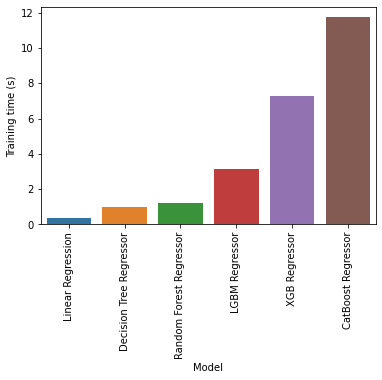

In [78]:
#grafica de tiempo de entrenamiento
sns.barplot(data=table.sort_values('Training time (s)'),x='Model',y='Training time (s)')
plt.xticks(rotation='vertical')
plt.show()

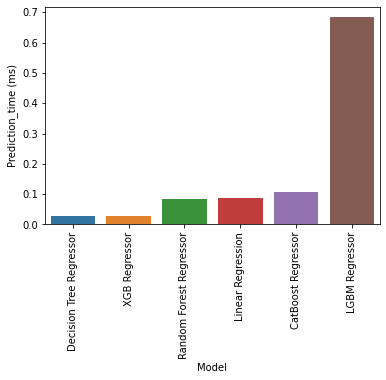

In [79]:
#grafica de tiempo de predicción
sns.barplot(data=table.sort_values('Prediction_time (ms)'),x='Model',y='Prediction_time (ms)')
plt.xticks(rotation='vertical')
plt.show()

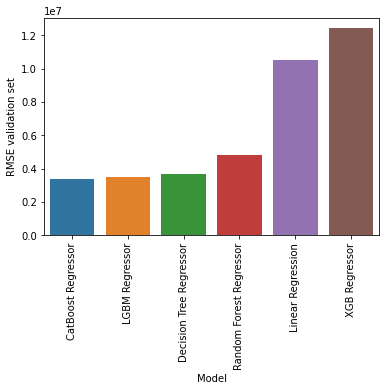

In [80]:
#grafica de RMS del conjunto de validación
sns.barplot(data=table.sort_values('RMSE validation set'),x='Model',y='RMSE validation set')
plt.xticks(rotation='vertical')
plt.show()

## Conclusiones

### Preparación de datos

Al preparar los datos se eliminaron datos debido a valores ausentes en distintas columnas. 

Asimismo, se rellenaron las columnas `VehicleType`, `FuelType` y `NotRepaired` con valores representativos.

Tras inspeccionar valores anormales, se eliminaron renglones con valores extrañamente bajos en las columnas `Price` y `Power`. 

El análisis se llevo acabo con el 81.29 % de los datos originales.

### Modelos de entrenamiento


Tomando en cuenta que los parámetros de interes son:
- el tiempo requerido para el entrenamiento
- la velocidad de la predicción
- la calidad de la predicción

Al comparar los tiempos de entrenamiento, los mejores son:
1. la regresión lineal
2. el árbol de regresión 
3. el bosque de regresión

El modelo de CatBoost tiene el mayor tiempo de entrenamiento, incluso duplica los tiempos de otros modelos.

Al comparar los tiempos de predicción, los mejores son:
1. el árbol de regresión 
2. el modelo XGBoost
3. el bosque de regresión

Al analizar la calidad de las predicciones, las mejores son del:
1. modelo de CatBoost
2. modelo de LightGBM
3. árbol de regresión 

Partiendo de la calidad de los modelos, el modelo de CatBoost tiene un tiempo de entrenamiento muy alto, comparado con los otros modelos y el modelo de LightGBM tiene un alto tiempo de predicción y un alto valor RMSE. Esto los descarta como los mejores modelos. 

Al buscar un modelo con buen desempeño en todos los parámetros de interes, se recomienda el uso del **árbol de regresión** ya que siempre aparece en los mejores 3 en los parámetros de interes.